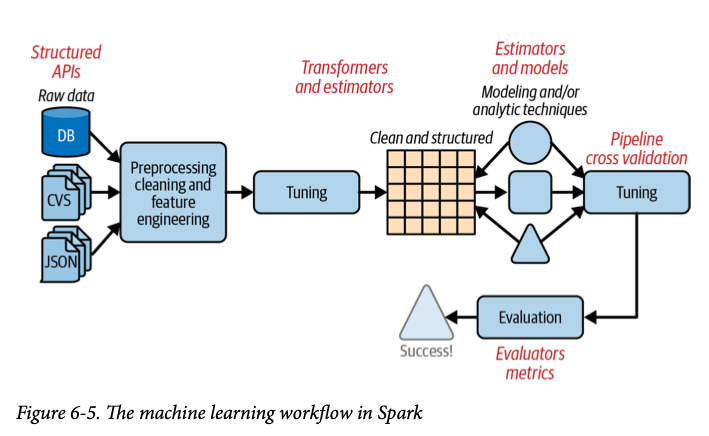

In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.master("local[*]").appName("Intro").getOrCreate()

24/01/16 13:25:56 WARN Utils: Your hostname, quangtn933.local resolves to a loopback address: 127.0.0.1; using 192.168.1.90 instead (on interface en0)
24/01/16 13:25:56 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/16 13:25:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/01/16 13:26:14 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [3]:
from pyspark.sql.types import StructField, StructType, StringType, DoubleType

In [5]:
custom_schema=StructType([
    StructField("Make", StringType(), True),
    StructField("Model", StringType(), True),
    StructField("Vehicle Class", StringType(), True),
    StructField("Cyclinders", DoubleType(), True),
    StructField("Transmission", StringType(), True),
    StructField("Fuel Type", StringType(), True),
    StructField("Fuel Consumption City (L/100 km)", DoubleType(), True),
    StructField("Fuel Consumption Hwy (L/100 km)", DoubleType(), True),
    StructField("Fuel Consumption Comb (L/100 km)", DoubleType(), True),
    StructField("Fuel Consumption Comb (mpg)", DoubleType(), True),
    StructField("CO2", DoubleType(), True)])

## Loading data

In [7]:
co2_data = spark.read.format("csv").schema(custom_schema).option("header", True) \
            .load("datasets/CO2_Emissions_Canada.csv")

In [9]:
co2_data.take(3)

24/01/16 13:32:33 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 12, schema size: 11
CSV file: file:///Users/quangtn/Desktop/01_work/01_job/02_ml/PySpark/ml-with-apache-spark/datasets/CO2_Emissions_Canada.csv


[Row(Make='ACURA', Model='ILX', Vehicle Class='COMPACT', Cyclinders=2.0, Transmission='4', Fuel Type='AS5', Fuel Consumption City (L/100 km)=None, Fuel Consumption Hwy (L/100 km)=9.9, Fuel Consumption Comb (L/100 km)=6.7, Fuel Consumption Comb (mpg)=8.5, CO2=33.0),
 Row(Make='ACURA', Model='ILX', Vehicle Class='COMPACT', Cyclinders=2.4, Transmission='4', Fuel Type='M6', Fuel Consumption City (L/100 km)=None, Fuel Consumption Hwy (L/100 km)=11.2, Fuel Consumption Comb (L/100 km)=7.7, Fuel Consumption Comb (mpg)=9.6, CO2=29.0),
 Row(Make='ACURA', Model='ILX HYBRID', Vehicle Class='COMPACT', Cyclinders=1.5, Transmission='4', Fuel Type='AV7', Fuel Consumption City (L/100 km)=None, Fuel Consumption Hwy (L/100 km)=6.0, Fuel Consumption Comb (L/100 km)=5.8, Fuel Consumption Comb (mpg)=5.9, CO2=48.0)]

In [10]:
cols_only_continues_values = {'Fuel Consumption City (L/100 km)':0}

In [11]:
co2_data = co2_data.fillna(0.0)

In [12]:
co2_data.printSchema()

root
 |-- Make: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Vehicle Class: string (nullable = true)
 |-- Cyclinders: double (nullable = false)
 |-- Transmission: string (nullable = true)
 |-- Fuel Type: string (nullable = true)
 |-- Fuel Consumption City (L/100 km): double (nullable = false)
 |-- Fuel Consumption Hwy (L/100 km): double (nullable = false)
 |-- Fuel Consumption Comb (L/100 km): double (nullable = false)
 |-- Fuel Consumption Comb (mpg): double (nullable = false)
 |-- CO2: double (nullable = false)



## Prepare data for regression

In [16]:
from pyspark.ml.feature import FeatureHasher
from pyspark.sql.functions import col

In [17]:
cols = ["Make", "Model", "Vehicle Class", "Cyclinders", "Transmission", "Fuel Type",
        "Fuel Consumption City (L/100 km)", "Fuel Consumption Hwy (L/100 km)",
        "Fuel Consumption Comb (L/100 km)", "Fuel Consumption Comb (mpg)"]

In [18]:
cols_only_continues = ["Fuel Consumption City (L/100 km)",
                       "Fuel Consumption Hwy (L/100 km)",
                       "Fuel Consumption Comb (L/100 km)"]

In [26]:
hasher = FeatureHasher(outputCol="hashed_features", inputCols=cols_only_continues)

In [27]:
data = hasher.transform(co2_data)

In [28]:
data.select("hashed_features").show(5, truncate=False)

+---------------------------------------------+
|hashed_features                              |
+---------------------------------------------+
|(262144,[38607,109231,228390],[0.0,9.9,6.7]) |
|(262144,[38607,109231,228390],[0.0,11.2,7.7])|
|(262144,[38607,109231,228390],[0.0,6.0,5.8]) |
|(262144,[38607,109231,228390],[0.0,12.7,9.1])|
|(262144,[38607,109231,228390],[0.0,12.1,8.7])|
+---------------------------------------------+
only showing top 5 rows



24/01/16 13:48:04 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Fuel Type, Fuel Consumption City (L/100 km), Fuel Consumption Hwy (L/100 km)
 Schema: Fuel Consumption City (L/100 km), Fuel Consumption Hwy (L/100 km), Fuel Consumption Comb (L/100 km)
Expected: Fuel Consumption City (L/100 km) but found: Fuel Type
CSV file: file:///Users/quangtn/Desktop/01_work/01_job/02_ml/PySpark/ml-with-apache-spark/datasets/CO2_Emissions_Canada.csv


In [29]:
data.select("hashed_features").take(1)

24/01/16 13:48:21 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Fuel Type, Fuel Consumption City (L/100 km), Fuel Consumption Hwy (L/100 km)
 Schema: Fuel Consumption City (L/100 km), Fuel Consumption Hwy (L/100 km), Fuel Consumption Comb (L/100 km)
Expected: Fuel Consumption City (L/100 km) but found: Fuel Type
CSV file: file:///Users/quangtn/Desktop/01_work/01_job/02_ml/PySpark/ml-with-apache-spark/datasets/CO2_Emissions_Canada.csv


[Row(hashed_features=SparseVector(262144, {38607: 0.0, 109231: 9.9, 228390: 6.7}))]

In [30]:
data.printSchema()

root
 |-- Make: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Vehicle Class: string (nullable = true)
 |-- Cyclinders: double (nullable = false)
 |-- Transmission: string (nullable = true)
 |-- Fuel Type: string (nullable = true)
 |-- Fuel Consumption City (L/100 km): double (nullable = false)
 |-- Fuel Consumption Hwy (L/100 km): double (nullable = false)
 |-- Fuel Consumption Comb (L/100 km): double (nullable = false)
 |-- Fuel Consumption Comb (mpg): double (nullable = false)
 |-- CO2: double (nullable = false)
 |-- hashed_features: vector (nullable = true)



## Time for selecting the most meaningful features

In [31]:
from pyspark.ml.feature import UnivariateFeatureSelector

In [32]:
selector = UnivariateFeatureSelector(outputCol="selectedFeatures",
                        featuresCol="hashed_features", labelCol="CO2")

In [33]:
selector.setFeatureType("continuous")
selector.setLabelType("continuous")

UnivariateFeatureSelector_4628affe0c86

In [34]:
model = selector.fit(data)
data = model.transform(data)

24/01/16 13:51:27 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Fuel Type, Fuel Consumption City (L/100 km), Fuel Consumption Hwy (L/100 km), Fuel Consumption Comb (mpg)
 Schema: Fuel Consumption City (L/100 km), Fuel Consumption Hwy (L/100 km), Fuel Consumption Comb (L/100 km), CO2
Expected: Fuel Consumption City (L/100 km) but found: Fuel Type
CSV file: file:///Users/quangtn/Desktop/01_work/01_job/02_ml/PySpark/ml-with-apache-spark/datasets/CO2_Emissions_Canada.csv
24/01/16 13:51:31 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/01/16 13:51:31 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Fuel Type, Fuel Consumption City (L/100 km), Fuel Consumption Hwy (L/100 km), Fuel Consumption Comb (mpg)
 Schema: Fuel Consumption City (L/100 km), Fuel Consumption Hwy (L/100 km), Fuel Consumption Comb (L/100 km), CO2
Expected: Fuel Consumption City (L/100 km) but found: Fuel Type
CSV file: file:///Users/quangtn/Desk

In [35]:
data.show(5)

+-----+----------+-------------+----------+------------+---------+--------------------------------+-------------------------------+--------------------------------+---------------------------+----+--------------------+--------------------+
| Make|     Model|Vehicle Class|Cyclinders|Transmission|Fuel Type|Fuel Consumption City (L/100 km)|Fuel Consumption Hwy (L/100 km)|Fuel Consumption Comb (L/100 km)|Fuel Consumption Comb (mpg)| CO2|     hashed_features|    selectedFeatures|
+-----+----------+-------------+----------+------------+---------+--------------------------------+-------------------------------+--------------------------------+---------------------------+----+--------------------+--------------------+
|ACURA|       ILX|      COMPACT|       2.0|           4|      AS5|                             0.0|                            9.9|                             6.7|                        8.5|33.0|(262144,[38607,10...|(50,[48,49],[9.9,...|
|ACURA|       ILX|      COMPACT|       2

24/01/16 13:52:34 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 12, schema size: 11
CSV file: file:///Users/quangtn/Desktop/01_work/01_job/02_ml/PySpark/ml-with-apache-spark/datasets/CO2_Emissions_Canada.csv


### LDA clustering algorithm

In [36]:
from pyspark.ml.linalg import Vectors, SparseVector
from pyspark.ml.clustering import LDA

In [40]:
lda = LDA(k=2, seed=1, optimizer="em", featuresCol="selectedFeatures")
lda.setMaxIter(100)

LDA_133b2aa5cd7f

In [41]:
lda.clear(lda.maxIter)
lda_model=lda.fit(data)
lda_model.setSeed(1)

24/01/16 13:56:14 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Fuel Type, Fuel Consumption City (L/100 km), Fuel Consumption Hwy (L/100 km)
 Schema: Fuel Consumption City (L/100 km), Fuel Consumption Hwy (L/100 km), Fuel Consumption Comb (L/100 km)
Expected: Fuel Consumption City (L/100 km) but found: Fuel Type
CSV file: file:///Users/quangtn/Desktop/01_work/01_job/02_ml/PySpark/ml-with-apache-spark/datasets/CO2_Emissions_Canada.csv
24/01/16 13:56:15 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Fuel Type, Fuel Consumption City (L/100 km), Fuel Consumption Hwy (L/100 km)
 Schema: Fuel Consumption City (L/100 km), Fuel Consumption Hwy (L/100 km), Fuel Consumption Comb (L/100 km)
Expected: Fuel Consumption City (L/100 km) but found: Fuel Type
CSV file: file:///Users/quangtn/Desktop/01_work/01_job/02_ml/PySpark/ml-with-apache-spark/datasets/CO2_Emissions_Canada.csv
24/01/16 13:56:15 WARN CSVHeaderChecker: CSV header does not confo

DistributedLDAModel: uid=LDA_133b2aa5cd7f, k=2, numFeatures=50

In [42]:
# check if the model itself is distributed accross Spark executes
lda_model.isDistributed()

True

In [43]:
lda_model.describeTopics().show()

+-----+-----------+--------------------+
|topic|termIndices|         termWeights|
+-----+-----------+--------------------+
|    0|   [48, 49]|[0.58104675033297...|
|    1|   [48, 49]|[0.58168999987474...|
+-----+-----------+--------------------+



In [44]:
lda_model.vocabSize()

50

In [45]:
lda_predictions = lda_model.transform(data)

In [46]:
lda_predictions.printSchema()

root
 |-- Make: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Vehicle Class: string (nullable = true)
 |-- Cyclinders: double (nullable = false)
 |-- Transmission: string (nullable = true)
 |-- Fuel Type: string (nullable = true)
 |-- Fuel Consumption City (L/100 km): double (nullable = false)
 |-- Fuel Consumption Hwy (L/100 km): double (nullable = false)
 |-- Fuel Consumption Comb (L/100 km): double (nullable = false)
 |-- Fuel Consumption Comb (mpg): double (nullable = false)
 |-- CO2: double (nullable = false)
 |-- hashed_features: vector (nullable = true)
 |-- selectedFeatures: vector (nullable = true)
 |-- topicDistribution: vector (nullable = true)



In [47]:
lda_predictions.select("topicDistribution").show(2, truncate=False)

+---------------------------------------+
|topicDistribution                      |
+---------------------------------------+
|[0.4999984467686334,0.5000015532313666]|
|[0.5000004890294165,0.4999995109705834]|
+---------------------------------------+
only showing top 2 rows



24/01/16 14:00:08 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Fuel Type, Fuel Consumption City (L/100 km), Fuel Consumption Hwy (L/100 km)
 Schema: Fuel Consumption City (L/100 km), Fuel Consumption Hwy (L/100 km), Fuel Consumption Comb (L/100 km)
Expected: Fuel Consumption City (L/100 km) but found: Fuel Type
CSV file: file:///Users/quangtn/Desktop/01_work/01_job/02_ml/PySpark/ml-with-apache-spark/datasets/CO2_Emissions_Canada.csv
24/01/16 14:00:08 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/01/16 14:00:08 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


In [48]:
lda_predictions.select("selectedFeatures").show(2, truncate=False)

+-----------------------+
|selectedFeatures       |
+-----------------------+
|(50,[48,49],[9.9,6.7]) |
|(50,[48,49],[11.2,7.7])|
+-----------------------+
only showing top 2 rows



24/01/16 14:01:08 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Fuel Type, Fuel Consumption City (L/100 km), Fuel Consumption Hwy (L/100 km)
 Schema: Fuel Consumption City (L/100 km), Fuel Consumption Hwy (L/100 km), Fuel Consumption Comb (L/100 km)
Expected: Fuel Consumption City (L/100 km) but found: Fuel Type
CSV file: file:///Users/quangtn/Desktop/01_work/01_job/02_ml/PySpark/ml-with-apache-spark/datasets/CO2_Emissions_Canada.csv


## KMeans

In [49]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans

In [50]:
kmeans = KMeans(k=3)
kmeans.setSeed(10)
kmeans.setFeaturesCol("selectedFeatures")

KMeans_71a05bbe1b97

In [51]:
kmeans_model = kmeans.fit(data)
kmeans_model.getDistanceMeasure()

24/01/16 14:14:11 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Fuel Type, Fuel Consumption City (L/100 km), Fuel Consumption Hwy (L/100 km)
 Schema: Fuel Consumption City (L/100 km), Fuel Consumption Hwy (L/100 km), Fuel Consumption Comb (L/100 km)
Expected: Fuel Consumption City (L/100 km) but found: Fuel Type
CSV file: file:///Users/quangtn/Desktop/01_work/01_job/02_ml/PySpark/ml-with-apache-spark/datasets/CO2_Emissions_Canada.csv
24/01/16 14:14:12 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Fuel Type, Fuel Consumption City (L/100 km), Fuel Consumption Hwy (L/100 km)
 Schema: Fuel Consumption City (L/100 km), Fuel Consumption Hwy (L/100 km), Fuel Consumption Comb (L/100 km)
Expected: Fuel Consumption City (L/100 km) but found: Fuel Type
CSV file: file:///Users/quangtn/Desktop/01_work/01_job/02_ml/PySpark/ml-with-apache-spark/datasets/CO2_Emissions_Canada.csv
24/01/16 14:14:12 WARN CSVHeaderChecker: CSV header does not confo

'euclidean'

In [53]:
kmeans_predictions = kmeans_model.transform(data)
kmeans_predictions.select("prediction").show(3)

+----------+
|prediction|
+----------+
|         0|
|         0|
|         0|
+----------+
only showing top 3 rows



24/01/16 14:15:12 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Fuel Type, Fuel Consumption City (L/100 km), Fuel Consumption Hwy (L/100 km)
 Schema: Fuel Consumption City (L/100 km), Fuel Consumption Hwy (L/100 km), Fuel Consumption Comb (L/100 km)
Expected: Fuel Consumption City (L/100 km) but found: Fuel Type
CSV file: file:///Users/quangtn/Desktop/01_work/01_job/02_ml/PySpark/ml-with-apache-spark/datasets/CO2_Emissions_Canada.csv


In [54]:
kmeans_predictions.select("prediction").distinct().show()

24/01/16 14:15:57 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Fuel Type, Fuel Consumption City (L/100 km), Fuel Consumption Hwy (L/100 km)
 Schema: Fuel Consumption City (L/100 km), Fuel Consumption Hwy (L/100 km), Fuel Consumption Comb (L/100 km)
Expected: Fuel Consumption City (L/100 km) but found: Fuel Type
CSV file: file:///Users/quangtn/Desktop/01_work/01_job/02_ml/PySpark/ml-with-apache-spark/datasets/CO2_Emissions_Canada.csv


+----------+
|prediction|
+----------+
|         1|
|         2|
|         0|
+----------+



In [55]:
summary = kmeans_model.summary

In [56]:
summary

In [57]:
summary.cluster.printSchema()

root
 |-- prediction: integer (nullable = false)



## Gaussian Mixture

In [59]:
from pyspark.ml.clustering import GaussianMixture

In [61]:
gm = GaussianMixture(k=42, tol=0.01, seed=10, featuresCol="selectedFeatures", maxIter=100)

In [62]:
gm_model = gm.fit(data)

24/01/16 14:25:05 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Fuel Type, Fuel Consumption City (L/100 km), Fuel Consumption Hwy (L/100 km)
 Schema: Fuel Consumption City (L/100 km), Fuel Consumption Hwy (L/100 km), Fuel Consumption Comb (L/100 km)
Expected: Fuel Consumption City (L/100 km) but found: Fuel Type
CSV file: file:///Users/quangtn/Desktop/01_work/01_job/02_ml/PySpark/ml-with-apache-spark/datasets/CO2_Emissions_Canada.csv
24/01/16 14:25:06 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
24/01/16 14:25:15 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Fuel Type, Fuel Consumption City (L/100 km), Fuel Consumption Hwy (L/100 km)
 Schema: Fuel Consumption City (L/100 km), Fuel Consumption Hwy (L/100 km), Fuel Consumption Comb (L/100 km)
Expected: Fuel Consumption City (L/100 km) but found: Fuel Type
CSV file: file:///Users/quangtn/Desktop/01_work/01_job/02_ml/PySpark/ml-with-ap

In [63]:
gm_predictions = gm_model.transform(data)

In [65]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
params = gm_model.explainParams()
pp.pprint(params)

('aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)\n'
 'featuresCol: features column name. (default: features, current: '
 'selectedFeatures)\n'
 'k: Number of independent Gaussians in the mixture model. Must be > 1. '
 '(default: 2, current: 42)\n'
 'maxIter: max number of iterations (>= 0). (default: 100, current: 100)\n'
 'predictionCol: prediction column name. (default: prediction)\n'
 'probabilityCol: Column name for predicted class conditional probabilities. '
 'Note: Not all models output well-calibrated probability estimates! These '
 'probabilities should be treated as confidences, not precise probabilities. '
 '(default: probability)\n'
 'seed: random seed. (default: 8154044584114310787, current: 10)\n'
 'tol: the convergence tolerance for iterative algorithms (>= 0). (default: '
 '0.01, current: 0.01)\n'
 'weightCol: weight column name. If this is not set or empty, we treat all '
 'instance weights as 1.0. (undefined)')


## Constructing the pipeline API

In [66]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[hasher, selector, gm])
# Fit the pipeline to training data.
pipeline_model = pipeline.fit(co2_data)

24/01/16 14:52:09 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Fuel Type, Fuel Consumption City (L/100 km), Fuel Consumption Hwy (L/100 km), Fuel Consumption Comb (mpg)
 Schema: Fuel Consumption City (L/100 km), Fuel Consumption Hwy (L/100 km), Fuel Consumption Comb (L/100 km), CO2
Expected: Fuel Consumption City (L/100 km) but found: Fuel Type
CSV file: file:///Users/quangtn/Desktop/01_work/01_job/02_ml/PySpark/ml-with-apache-spark/datasets/CO2_Emissions_Canada.csv
24/01/16 14:52:10 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/01/16 14:52:10 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Fuel Type, Fuel Consumption City (L/100 km), Fuel Consumption Hwy (L/100 km), Fuel Consumption Comb (mpg)
 Schema: Fuel Consumption City (L/100 km), Fuel Consumption Hwy (L/100 km), Fuel Consumption Comb (L/100 km), CO2
Expected: Fuel Consumption City (L/100 km) but found: Fuel Type
CSV file: file:///Users/quangtn/Desk

In [67]:
transformed_by_pipeline = pipeline_model.transform(co2_data)

In [69]:
transformed_by_pipeline.printSchema()

root
 |-- Make: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Vehicle Class: string (nullable = true)
 |-- Cyclinders: double (nullable = false)
 |-- Transmission: string (nullable = true)
 |-- Fuel Type: string (nullable = true)
 |-- Fuel Consumption City (L/100 km): double (nullable = false)
 |-- Fuel Consumption Hwy (L/100 km): double (nullable = false)
 |-- Fuel Consumption Comb (L/100 km): double (nullable = false)
 |-- Fuel Consumption Comb (mpg): double (nullable = false)
 |-- CO2: double (nullable = false)
 |-- hashed_features: vector (nullable = true)
 |-- selectedFeatures: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: integer (nullable = false)



## Evaluating clustering models

In [70]:
from pyspark.ml.evaluation import ClusteringEvaluator

In [71]:
evaluator = ClusteringEvaluator(featuresCol="selectedFeatures")
evaluator.setPredictionCol("prediction")

ClusteringEvaluator_de27f2c199dd

In [72]:
# evaluate with euclide distance
print("Kmeans: " + str(evaluator.evaluate(kmeans_predictions)))
print("GM: " + str(evaluator.evaluate(gm_predictions)))

24/01/16 14:56:39 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Fuel Type, Fuel Consumption City (L/100 km), Fuel Consumption Hwy (L/100 km)
 Schema: Fuel Consumption City (L/100 km), Fuel Consumption Hwy (L/100 km), Fuel Consumption Comb (L/100 km)
Expected: Fuel Consumption City (L/100 km) but found: Fuel Type
CSV file: file:///Users/quangtn/Desktop/01_work/01_job/02_ml/PySpark/ml-with-apache-spark/datasets/CO2_Emissions_Canada.csv
24/01/16 14:56:41 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Fuel Type, Fuel Consumption City (L/100 km), Fuel Consumption Hwy (L/100 km)
 Schema: Fuel Consumption City (L/100 km), Fuel Consumption Hwy (L/100 km), Fuel Consumption Comb (L/100 km)
Expected: Fuel Consumption City (L/100 km) but found: Fuel Type
CSV file: file:///Users/quangtn/Desktop/01_work/01_job/02_ml/PySpark/ml-with-apache-spark/datasets/CO2_Emissions_Canada.csv


Kmeans: 0.6791002214675337


24/01/16 14:56:42 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Fuel Type, Fuel Consumption City (L/100 km), Fuel Consumption Hwy (L/100 km)
 Schema: Fuel Consumption City (L/100 km), Fuel Consumption Hwy (L/100 km), Fuel Consumption Comb (L/100 km)
Expected: Fuel Consumption City (L/100 km) but found: Fuel Type
CSV file: file:///Users/quangtn/Desktop/01_work/01_job/02_ml/PySpark/ml-with-apache-spark/datasets/CO2_Emissions_Canada.csv
24/01/16 14:56:46 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Fuel Type, Fuel Consumption City (L/100 km), Fuel Consumption Hwy (L/100 km)
 Schema: Fuel Consumption City (L/100 km), Fuel Consumption Hwy (L/100 km), Fuel Consumption Comb (L/100 km)
Expected: Fuel Consumption City (L/100 km) but found: Fuel Type
CSV file: file:///Users/quangtn/Desktop/01_work/01_job/02_ml/PySpark/ml-with-apache-spark/datasets/CO2_Emissions_Canada.csv


GM: -0.1517797715036008


In [73]:
evaluator.isLargerBetter()

True

In [74]:
evaluator.explainParams()

"distanceMeasure: The distance measure. Supported options: 'squaredEuclidean' and 'cosine'. (default: squaredEuclidean)\nfeaturesCol: features column name. (default: features, current: selectedFeatures)\nmetricName: metric name in evaluation (silhouette) (default: silhouette)\npredictionCol: prediction column name. (default: prediction, current: prediction)\nweightCol: weight column name. If this is not set or empty, we treat all instance weights as 1.0. (undefined)"

## Hyperparameters and Tuning experiments

In [75]:
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder

In [77]:
grid = ParamGridBuilder().addGrid(kmeans.maxIter, [20, 50, 100]).build()

tvs = TrainValidationSplit(estimator=kmeans, estimatorParamMaps=grid, evaluator=evaluator,
                           collectSubModels=True, parallelism=1, seed=42)

In [78]:
tvs_model = tvs.fit(data)
tvs_model.getTrainRatio()

24/01/16 15:01:55 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 12, schema size: 11
CSV file: file:///Users/quangtn/Desktop/01_work/01_job/02_ml/PySpark/ml-with-apache-spark/datasets/CO2_Emissions_Canada.csv
24/01/16 15:02:03 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 12, schema size: 11
CSV file: file:///Users/quangtn/Desktop/01_work/01_job/02_ml/PySpark/ml-with-apache-spark/datasets/CO2_Emissions_Canada.csv
24/01/16 15:02:14 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Fuel Type, Fuel Consumption City (L/100 km), Fuel Consumption Hwy (L/100 km)
 Schema: Fuel Consumption City (L/100 km), Fuel Consumption Hwy (L/100 km), Fuel Consumption Comb (L/100 km)
Expected: Fuel Consumption City (L/100 km) but found: Fuel Type
CSV file: file:///Users/quangtn/Desktop/01_work/01_job/02_ml/PySpark/ml-with-apache-spark/dataset

0.75

In [79]:
tvs_model.validationMetrics

[0.6843684538859846, 0.6837861506601989, 0.6837861506601989]

In [81]:
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder

grid = ParamGridBuilder().addGrid(kmeans.maxIter, [20, 50, 100]) \
            .addGrid(kmeans.distanceMeasure, ['euclidean', 'cosine']).build()

In [82]:
tvs_model.validationMetrics

[0.6843684538859846, 0.6837861506601989, 0.6837861506601989]

In [84]:
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder

grid = ParamGridBuilder().addGrid(kmeans.maxIter, [20, 50, 100]) \
        .addGrid(kmeans.distanceMeasure, ['euclidean', 'cosine']) \
        .addGrid(evaluator.distanceMeasure, ['euclidean', 'cosine']).build()

In [86]:
tvs = TrainValidationSplit(estimator=kmeans, estimatorParamMaps=grid, evaluator=evaluator,
                           collectSubModels=True, parallelism=1, seed=42, trainRatio=0.8)

In [87]:
tvs_model = tvs.fit(data)
tvs_model.validationMetrics

24/01/16 15:08:11 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 12, schema size: 11
CSV file: file:///Users/quangtn/Desktop/01_work/01_job/02_ml/PySpark/ml-with-apache-spark/datasets/CO2_Emissions_Canada.csv
24/01/16 15:08:17 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 12, schema size: 11
CSV file: file:///Users/quangtn/Desktop/01_work/01_job/02_ml/PySpark/ml-with-apache-spark/datasets/CO2_Emissions_Canada.csv
24/01/16 15:08:57 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Fuel Type, Fuel Consumption City (L/100 km), Fuel Consumption Hwy (L/100 km)
 Schema: Fuel Consumption City (L/100 km), Fuel Consumption Hwy (L/100 km), Fuel Consumption Comb (L/100 km)
Expected: Fuel Consumption City (L/100 km) but found: Fuel Type
CSV file: file:///Users/quangtn/Desktop/01_work/01_job/02_ml/PySpark/ml-with-apache-spark/dataset

[0.6787453248970768,
 0.6787453248970768,
 -0.021605321361607754,
 -0.021605321361607754,
 0.6787453248970768,
 0.6787453248970768,
 -0.021605321361607754,
 -0.021605321361607754,
 0.6787453248970768,
 0.6787453248970768,
 -0.021605321361607754,
 -0.021605321361607754]

## Adding evaluator to the grid params:

In [88]:
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder

In [93]:
grid = ParamGridBuilder().addGrid(kmeans.maxIter, [20, 50, 100]) \
        .addGrid(kmeans.distanceMeasure, ['euclidean', 'cosine']) \
        .addGrid(evaluator.distanceMeasure, ['euclidean', 'cosine']) \
        .baseOn({kmeans.featuresCol:  "selectedFeatures"}) \
        .build()

In [97]:
tvs = TrainValidationSplit(estimator=kmeans, estimatorParamMaps=grid, evaluator=evaluator,
                           collectSubModels=True, parallelism=1, seed=42, trainRatio=0.8)

In [98]:
tvs_model = tvs.fit(data)

24/01/16 15:20:39 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 12, schema size: 11
CSV file: file:///Users/quangtn/Desktop/01_work/01_job/02_ml/PySpark/ml-with-apache-spark/datasets/CO2_Emissions_Canada.csv
24/01/16 15:20:44 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 12, schema size: 11
CSV file: file:///Users/quangtn/Desktop/01_work/01_job/02_ml/PySpark/ml-with-apache-spark/datasets/CO2_Emissions_Canada.csv
24/01/16 15:21:25 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Fuel Type, Fuel Consumption City (L/100 km), Fuel Consumption Hwy (L/100 km)
 Schema: Fuel Consumption City (L/100 km), Fuel Consumption Hwy (L/100 km), Fuel Consumption Comb (L/100 km)
Expected: Fuel Consumption City (L/100 km) but found: Fuel Type
CSV file: file:///Users/quangtn/Desktop/01_work/01_job/02_ml/PySpark/ml-with-apache-spark/dataset

In [99]:
tvs_model.validationMetrics

[0.6787453248970768,
 0.6787453248970768,
 -0.021605321361607754,
 -0.021605321361607754,
 0.6787453248970768,
 0.6787453248970768,
 -0.021605321361607754,
 -0.021605321361607754,
 0.6787453248970768,
 0.6787453248970768,
 -0.021605321361607754,
 -0.021605321361607754]

In [100]:
tvs_model.subModels

[KMeansModel: uid=KMeans_71a05bbe1b97, k=3, distanceMeasure=euclidean, numFeatures=50,
 KMeansModel: uid=KMeans_71a05bbe1b97, k=3, distanceMeasure=euclidean, numFeatures=50,
 KMeansModel: uid=KMeans_71a05bbe1b97, k=3, distanceMeasure=cosine, numFeatures=50,
 KMeansModel: uid=KMeans_71a05bbe1b97, k=3, distanceMeasure=cosine, numFeatures=50,
 KMeansModel: uid=KMeans_71a05bbe1b97, k=3, distanceMeasure=euclidean, numFeatures=50,
 KMeansModel: uid=KMeans_71a05bbe1b97, k=3, distanceMeasure=euclidean, numFeatures=50,
 KMeansModel: uid=KMeans_71a05bbe1b97, k=3, distanceMeasure=cosine, numFeatures=50,
 KMeansModel: uid=KMeans_71a05bbe1b97, k=3, distanceMeasure=cosine, numFeatures=50,
 KMeansModel: uid=KMeans_71a05bbe1b97, k=3, distanceMeasure=euclidean, numFeatures=50,
 KMeansModel: uid=KMeans_71a05bbe1b97, k=3, distanceMeasure=euclidean, numFeatures=50,
 KMeansModel: uid=KMeans_71a05bbe1b97, k=3, distanceMeasure=cosine, numFeatures=50,
 KMeansModel: uid=KMeans_71a05bbe1b97, k=3, distanceMeasur

In [101]:
arr_models = tvs_model.subModels

## Advanced Split

In [102]:
from pyspark.ml.tuning import CrossValidator, CrossValidatorModel

In [111]:
cv = CrossValidator(estimator=kmeans, estimatorParamMaps=grid, evaluator=evaluator,
                    collectSubModels=True, parallelism=2, numFolds=3)

In [112]:
cv_model = cv.fit(data)
cv_model.subModels

24/01/16 15:29:43 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 12, schema size: 11
CSV file: file:///Users/quangtn/Desktop/01_work/01_job/02_ml/PySpark/ml-with-apache-spark/datasets/CO2_Emissions_Canada.csv
24/01/16 15:29:52 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 12, schema size: 11
CSV file: file:///Users/quangtn/Desktop/01_work/01_job/02_ml/PySpark/ml-with-apache-spark/datasets/CO2_Emissions_Canada.csv
24/01/16 15:29:52 WARN BlockManager: Block rdd_7095_0 already exists on this machine; not re-adding it
24/01/16 15:30:21 WARN CSVHeaderChecker: Number of column in CSV header is not equal to number of fields in the schema:
 Header length: 12, schema size: 11
CSV file: file:///Users/quangtn/Desktop/01_work/01_job/02_ml/PySpark/ml-with-apache-spark/datasets/CO2_Emissions_Canada.csv
24/01/16 15:30:28 WARN CSVHeaderChecker: Number of column

[[KMeansModel: uid=KMeans_71a05bbe1b97, k=3, distanceMeasure=euclidean, numFeatures=50,
  KMeansModel: uid=KMeans_71a05bbe1b97, k=3, distanceMeasure=euclidean, numFeatures=50,
  KMeansModel: uid=KMeans_71a05bbe1b97, k=3, distanceMeasure=cosine, numFeatures=50,
  KMeansModel: uid=KMeans_71a05bbe1b97, k=3, distanceMeasure=cosine, numFeatures=50,
  KMeansModel: uid=KMeans_71a05bbe1b97, k=3, distanceMeasure=euclidean, numFeatures=50,
  KMeansModel: uid=KMeans_71a05bbe1b97, k=3, distanceMeasure=euclidean, numFeatures=50,
  KMeansModel: uid=KMeans_71a05bbe1b97, k=3, distanceMeasure=cosine, numFeatures=50,
  KMeansModel: uid=KMeans_71a05bbe1b97, k=3, distanceMeasure=cosine, numFeatures=50,
  KMeansModel: uid=KMeans_71a05bbe1b97, k=3, distanceMeasure=euclidean, numFeatures=50,
  KMeansModel: uid=KMeans_71a05bbe1b97, k=3, distanceMeasure=euclidean, numFeatures=50,
  KMeansModel: uid=KMeans_71a05bbe1b97, k=3, distanceMeasure=cosine, numFeatures=50,
  KMeansModel: uid=KMeans_71a05bbe1b97, k=3, di

In [117]:
cv_model.avgMetrics

[0.6772662365904969,
 0.6772662365904969,
 -0.023415743284285594,
 -0.023415743284285594,
 0.6773396141685529,
 0.6773396141685529,
 -0.023415743284285594,
 -0.023415743284285594,
 0.6773396141685529,
 0.6773396141685529,
 -0.023415743284285594,
 -0.023415743284285594]

## Persistence

In [124]:
#from pyspark.mllib.util.Saveable import save
path = "ml-with-apache-spark/saved_model"
#paths = "./"
cv_model.write().overwrite().save(path)

In [125]:
from pyspark.ml.tuning import CrossValidatorModel
read_model_from_disk = CrossValidatorModel.load(path)